In [2]:
"""
You need to run this cell for the code in following cells to work.
"""

# Enable module reloading
%load_ext autoreload
%autoreload 2

# Enable interactive plots
%matplotlib notebook

import sys
sys.path.append('..')

import week_3.tests.hub as tests
from week_3.backstage.load_data import load_data
from week_3.backstage.plots import add_magic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Week 3

__Goals for this week__

We will implement our first neural network - a _multilayer perceptron_ model capable of classification. This classical model is still widely used for processing vector data. We will also talk about train and test sets, i.e. how to split your data to properly evaluate the model you have trained. 

__How to solve this lab?__

Just follow this notebook and run all the code. When prompted complete the code in the referenced files. Correct answers for some exercises are provided at the bottom.

__Feedback__

This lab is a work in progress. If you notice a mistake, notify us or you can even make a pull request. Also please fill the [questionnaire](https://forms.gle/r27nBAvnMC7jbjJ58) after you finish this lab to give us feedback.


## Multilayer Perceptron

The first true neural network that we will use is _multilayer perceptron_ (MLP). It can also be called  _feed-forward_ model or _dense_ model in literature. The iconic illustration of neural networks shows this model:

![Multilayer Perceptron](images/mlp.svg)
<center><small>License: Glosser.ca <a href="https://creativecommons.org/licenses/by-sa/3.0">CC BY-SA 3.0</a>, via Wikimedia Commons</small></center>

Models like these consistsof several layers. First, there is an input layer - with model above we have an input with _three_ features. Then a series of neuron layers $\mathbf{h}_1, ..., \mathbf{h}_K$ comes. Each layer consists of several artificial neurons, where $i$-th neuron of $j$-th layer is defined as:

\begin{equation}
h_j^{i} = \sigma_j(\mathbf{w_j^i} \cdot \mathbf{h_{j-1}} + b_j^i)
\end{equation}

$\mathbf{w}_j^i$ and $b_j^i$ are parameters (weights and bias) for this particular neuron. $\mathbf{h}_{j-1}$ is the vector of values calculated for the neurons from previous layer (with $h_0$ being the input layer) and $\sigma$ is the activation function for this particular layer. Note that each neuron "sees" _all_ the neurons from the previous layer.

The final layer $h_K$ serves as an output of the model $\mathbf{\hat{y}}$. Note that we can have multiple output neurons, i.e. we can predict vectors of values, not only scalars. All the layers between input and ouput layers are considered _hidden_ layers.

The prediction $\mathbf{\hat{y}}$ from output layer is compared with expected value $\mathbf{y}$ via loss function, in the very same way we used these two term in previous lab, e.g. by using _mean squared error_. This loss function can be minimized by _stochastic gradient descent_ algorithm. The SGD for training neural networks is identical with the SGD algorithm we used to train linear regression.

### Defining MLP with Vectors and Matrices

Instead of calculating the values neuron by neuron, we can simplify the calculations with matrix operations:

\begin{equation}
\mathbf{z}_j = \mathbf{W}_j \mathbf{h}_{j-1} + \mathbf{b}_j
\end{equation}

\begin{equation}
\mathbf{h}_j = \sigma_j(z_j)
\end{equation}

Mathematically, this is the same as calculating the neuron one by one. Note that $i$-th row of $\mathbf{W}_j$ and $i$-th member of $\mathbf{b}_j$ are in fact the parameters for $i$-th neuron:

\begin{equation}
\mathbf{W}_j = \begin{bmatrix}\mathbf{w}_j^1 \\ \mathbf{w}_j^2 \\ \vdots \\ \mathbf{w}_j^M \end{bmatrix}
\end{equation}

We introduced the $\mathbf{z}$ quantity because it will come handy later. It is sometimes called neuron pre-activation value.

__Exercise 3.1:__ What is the shape of $\mathbf{W}_j$ and $\mathbf{b}_j$?


### Architecture Decisions

__1. How many layers should the network have?__  
For smaller datasets you can easily go with only one or two hidden layers. For bigger dataset or more difficult tasks the number of layers grows and they can use tens of layers. Huge state-of-the art image recognition systems have [~100 convolutional hidden layers](https://paperswithcode.com/sota/image-classification-on-imagenet).

__2. How many neurons should be in the layers?__  
You can start with ~100 neurons for smaller datasets. The biggest current models can use several thousands of neurons per layer. The number of neurons is usually the same for all the hidden layers.

For both number of layers and number of neurons you should check relevant literature to see how big the models are for comparable datasets. We will talk about how to correctly set parameters like these in the future. 

__3. What activation functions should be used for individual layers?__  
All the hidden layers usually use the same activation function. In the past [sigmoid functions](https://en.wikipedia.org/wiki/Sigmoid_function) (functions with S shape) were popular. However in the recent years [rectifier functions](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) became the go-to activation functions for neural networks training. You can use either _ReLU_ or some of its variants, such as _Leaky ReLU_ as a good starting point.

For output layer the activation function is usually different. Here we need to customize the function to fit the task, e.g. when we do regression and we want to have the results between 0 and 1, we can use the logistic regression function. When we do regression for all real numbers, we can use linear function instead.

### Training MLP

MLP can be trained with stochastic gradient descent. The general outline of the SGD algorithm is exactly the same as with linear regression from last week's lab. The equations for the derivatives are:

\begin{equation}
\frac{dL}{d\mathbf{W}_n} = \frac{dL}{d\mathbf{z}_n} \mathbf{h}_{n-1}^T
\end{equation}

\begin{equation}
\frac{dL}{db_n} = \frac{dL}{d\mathbf{z}_n}
\end{equation}

Next we need to calculate $\frac{dL}{d\mathbf{z}_n}$. For all layers, but the last it is defined as:

\begin{equation}
\frac{dL}{d\mathbf{z}_n} = (\mathbf{W}_{n+1}^T\frac{dL}{d\mathbf{z}_{n+1}}) \odot \sigma_n'(\mathbf{z}_n)
\end{equation}

$\odot$ is [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)). Note that in the last term we do not use the activation function $\sigma$, but its derivative $\sigma'$, e.g. if the activation function would be $x^2$, its derivative used here would be $2x$.

For the last $K$-th layer the equation is:

\begin{equation}
\frac{dL}{d\mathbf{z}_K} = \frac{dL}{d\mathbf{h}_K} \odot \sigma_K'(\mathbf{z}_K)
\end{equation}

The term $\frac{dL}{d\mathbf{h}_K}$ is calculated according to the definition of loss function. If you are interested how these equations came to be, check out the _Further Reading_ section of this notebook.

## Classification

Classification is a second machine learning task we will try to solve (first being regression). With classification we aim to assign each sample to a class, while we have a predefined finite set of $C$ classes. E.g. we might want to take measurments of _Iris_ flowers and classify them into one of three possible _Iris_ species. We will work with this task as an example from now on.

The data look like this:

| | | | | |
| --- | --- | --- | --- | - |
| 5.0 | 3.3 | 1.4 | 0.2 | 0 |
| 7.0 | 3.2 | 4.7 | 1.4 | 1 |
| 5.7 | 2.8 | 4.1 | 1.3 | 1 |
| 6.3 | 3.3 | 6.0 | 2.5 | 2 |

The first four columns are measurments of the flowers:

- sepal length in cm
- sepal width in cm
- petal length in cm
- petal width in cm

The last column is a code fo _Iris_ species:
0. _Iris Setosa_
1. _Iris Versicolour_
2. _Iris Virginica_

<img src="images/iris.jpg" alt="Iris" width="500"/>
<center><small>License: Davefoc <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons</small></center>

__Exercise 3.2:__ Check out [A Neural Network Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=21&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3,3&seed=0.76883&showTestData=false&discretize=false&percTrainData=90&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=true&problem_hide=true&noise_hide=true&discretize_hide=false&regularization_hide=true&regularizationRate_hide=true&percTrainData_hide=true) for a great visualization of MLP classification. Observe how different settings change the behavior of the network, e.g. what happens when we have zero hidden layers and only the first two inputs are used? Compare the behavior with different learning rates. See how different activation functions behave. Try to undertand all the options that are provided by this tool.

__Exercise 3.3:__ Why should we not use linear function as an activation function? _Hint:_ Using Neural Network Playground: Pick only first two inputs, pick linear activation function. How does the output of the network looks like? Why?

To solve a general classification problem we propose a simple MLP model with one hidden layer. The two layers are defined as follows:

\begin{equation}
\mathbf{z}_1 = \mathbf{W}_1\mathbf{x} + \mathbf{b}_1
\end{equation}

\begin{equation}
\mathbf{h} = \sigma_1(\mathbf{z}_1)
\end{equation}

\begin{equation}
\mathbf{z}_2 = \mathbf{W}_2\mathbf{h} + \mathbf{b}_2
\end{equation}

\begin{equation}
\mathbf{\hat{y}} = \sigma_2(\mathbf{z}_2)
\end{equation}

This just follows the general equation of MLP we showed above. The hidden layer $\mathbf{h}$ has a customizable size that can be set before the training. The output layer will have a size of 3, one output neuron for each _Iris_ class.

We will use logistic regression function for both $\sigma_1$ and $\sigma_2$. In the hidden layer, it simply serves as a non-linear function. In the output layer, it squishes the $\mathbf{z}_2$ into $(0, 1)$ range and thus we can interpret the outputs $\mathbf{\hat{y}}$ as probabilities. The $j$-th element of $\mathbf{\hat{y}}$ tells us what is the probability that the sample belongs to the $j$-th class. E.g. with ${\mathbf{\hat{y}} = [0.1, 0.8, 0.3]$ we can say that the model gives 10% probability for the first class, 80% for the second class and 30% for the third class. Note that they do not add up to 100%, this model calculates the probability for each class independently. 

The definition of logistic function $\sigma$ is as follows:

\begin{equation}
\sigma(x) = \frac{1}{1 + e^{-x}}
\end{equation}

Finally, we also need to define our loss function. We need to have a loss function that will compare the predicted probabilities with the true value - the true class of the sample. To do so we will apply _mean squared error_ loss function on the predicted values $\mathbf{\hat{y}}$ and the true value encoded with _one-hot encoding_. One-hot encoding of $j$-th class makes a vector of size $C$, where all components are $0$, except for the $j$-th component, which is $1$.

_Example:_ $\mathbf{\hat{y}}$ is a prediction that the model calculates. $\mathbf{y}$ is a true label we want to achieve. In this case the second element is $1$, so it encodes the second class -- _Iris Versicolour_.

\begin{equation}
\mathbf{\hat{y}} = \begin{bmatrix}0.1 \\ 0.8 \\ 0.3\end{bmatrix}\ \ \ \mathbf{y} = \begin{bmatrix}0 \\ 1 \\ 0\end{bmatrix}
\end{equation}

The loss function for $i$-th sample is then defined as:

\begin{equation}
L^{(i)} = \frac{\sum_{j=1}^C{(\hat{y}_j^{(i)} - y_j^{(i)})^2}}{C}
\end{equation}

The overall loss function is defined as an average of loss functions for all the samples, similarly as before.

__Practical Note:__ Logistic function and MSE are not usually used as activation function and loss function for classification problems. We have better options, but we will use these two in this lab because of their simplicity. In practice, we would use _softmax_ activation and _cross-entropy_ loss function. More information about these two is in the _Further Reading_ section.

### Training classifier

We need to calculate the derivatives for SGD. Following the general equations from earlier we can define the derivatives of parameters $\theta = \{ \mathbf{W}_1, \mathbf{b}_1, \mathbf{W}_2, \mathbf{b}_2 \}$ as:

\begin{equation}
\frac{dL}{d\mathbf{z}_2} = 2(\mathbf{\hat{y}} - \mathbf{y}) \odot \sigma'(\mathbf{z}_2)
\end{equation}

\begin{equation}
\frac{dL}{d\mathbf{W}_2} = \frac{dL}{d\mathbf{z}_2} \mathbf{h}^T
\end{equation}

\begin{equation}
\frac{dL}{d\mathbf{b}_2} = \frac{dL}{d\mathbf{z}_2}
\end{equation}

These are the definitions for second layer parameters. The derivative of activation function is: $\sigma'(x) = \sigma(x)(1 - \sigma(x))$. Otherwise these equations should be easy to understand. Then for the first layer, we just follow the general equations from before:

\begin{equation}
\frac{dL}{d\mathbf{z}_1} = (\mathbf{W}_2^T\frac{dL}{d\mathbf{z}_2}) \odot \sigma'(\mathbf{z}_1)
\end{equation}

\begin{equation}
\frac{dL}{d\mathbf{W}_1} = \frac{dL}{d\mathbf{z}_1} \mathbf{x}^T
\end{equation}

\begin{equation}
\frac{dL}{db_1} = \frac{dL}{d\mathbf{z}_1}
\end{equation}

For all these parameter matrices and vectors the SGD update rule is the same as before:

\begin{equation}
\theta_{i+1} = \theta_i - \alpha \frac{dL}{d\theta_i}
\end{equation}

### Programming Assignment 3.4: Multilayer Perceptron

With all the important equations defined above, you should now be able to implement a multilayer perceptron model for classification. Hidden layer should have customizable number of neurons, while output layer will have $C$ neurons. Use `mlp.py` as a starting point:

`__init__`, `init_weights` and `init_biases` serve to initialize the parameters of the model. We can not use the zero initialization for models with hidden layers. Instead we initialize the weights matrices with random values. We use the Xavier initialization scheme (sometimes also called Glorot initialization) [1].

`loss`, `stochastic_gradient_descent`, `epoch` and `step` methods should remind you of last week's lab. There is nothing new in these, the SGD algorithm remains the same. For simplicity, we only work with batch size of 1 this week.

`sigma` and `dsigma` are the implementation of $\sigma$ and $\sigma'$ functions respectively.

You should understand the prepared code before you proceed.

#### 3.4.1

You need to complete the `predict` method. This method implements the _forward pass_ of backpropagation algorithm. First, try to complete the missing values of dimensions of return values in the signature of the method. This should help you realize how are the quantities shaped.

Then calculate the individual quantities following the equations above: $\mathbf{z}_1$, $\mathbf{h}$, $\mathbf{z}_2$ and $\mathbf{\hat{y}}$. You should return the values of all the quantities as suggested in the method signature. You can use the `sigma` method for activation function.

#### 3.4.2

Then you need to complete the `gradient` method. This method implements the _backward pass_. When we calculate the derivatives, we go in the opposite direction, i.e. we first calculate the derivatives for the second layer and then we use the intermediate results to calculate the derivatives for the first layer.

Again, try to complete the missing values of dimensions of return values in the signature of the method. Then follow the above mentioned definitions of $\frac{dL}{d\mathbf{W}_1}$, $\frac{dL}{d\mathbf{b}_1}$, $\frac{dL}{d\mathbf{W}_2}$ and $\frac{dL}{d\mathbf{b})2}$. Note, that there are quantities that are being use repeatedly, e.g. for both $\frac{dL}{d\mathbf{W}_2}$ and $\frac{dL}{d\mathbf{b}_2}$ we need to calculate $\frac{dL}{d\mathbf{z}_2}$. In cases like these, you should make the calculation only once and store the results for later.

Quantities from forward pass $\mathbf{z}_1$, $\mathbf{h}$ and $\mathbf{z}_2$ are in the definitions as well. These quantities are calculated in the `predict` method that is called at the start of `gradient`.

__Numpy note:__ Use the `*` operator for Hadamard product and the `@` operator for matrix multiplication.

..
----------------------------------------------------------------------
Ran 2 tests in 0.006s

OK


<IPython.core.display.Javascript object>


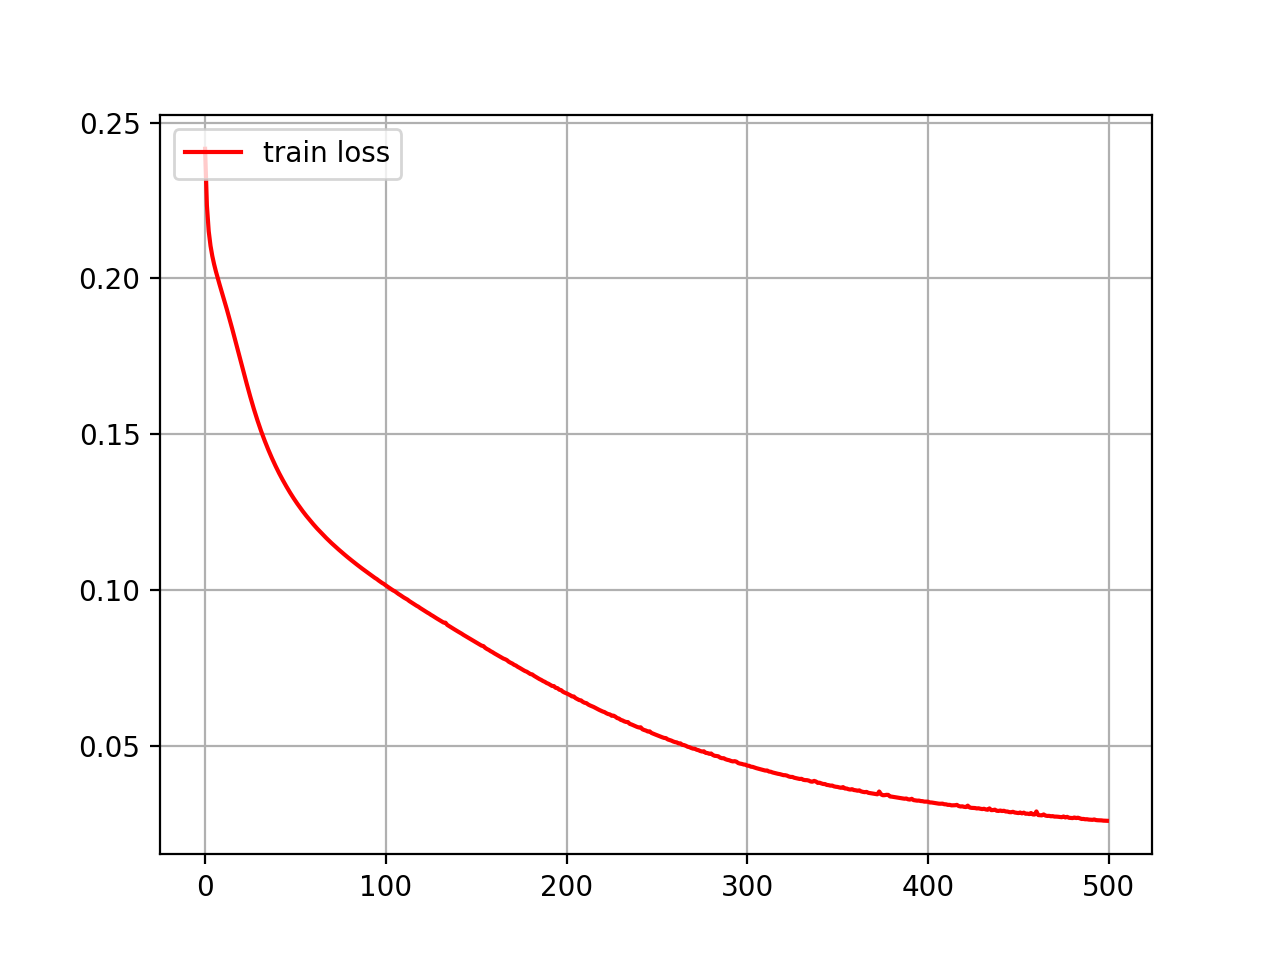

In [26]:
from week_3.mlp import MultilayerPerceptron
    
if tests.mlp_test():
    
    dim_input = 4    # 4 features
    dim_hidden = 10  # You can change this
    dim_output = 3   # 3 classes

    data = load_data('iris.csv', num_classes=dim_output)
    model = MultilayerPerceptron(dim_input, dim_hidden, dim_output)
    add_magic(model)
    model.stochastic_gradient_descent(data.x, data.y)

__Exercise 3.5:__ We initialize the weights with random values. Try to change this initialization to zero. How does this affect the loss function value? Can you diagnose what is the problem with this initialization? _Hint:_ Try printing the values for various quantities.

## Evaluating models

Minimizing loss function is how we train neural networks. However it has two drawbacks for other practical uses:

1. The loss function describes how well we fit the data we show the model. But we want to know how well does the model work on data it has not seen before. E.g. machine translation system that can only translate the sentences it has seen before is not very useful.

  To solve this issue we split the data we have into two __non-overlapping__ sets - _training_ set and _testing_ set. Training set is used to train the model, i.e. to directly minimize the loss function. Testing set is then used to evaluate how well does the model work on data it has _not seen_ before.
  

2. Loss function is a rather abstact quantity. It is hard to tell how well does a model with loss $0.2$ perform. or whether a model with loss $0.19$ is significantly better.

  To solve this issue, we should use a more straightforward metric for evaluation. For example for classification we can use an _accuracy_ instead. Accuracy tells us the percentage of samples we are able to classify successfully - i.e. how many samples has the highest prediction value for correct class.

### Programming Assignment 3.6: Model Evaluation [2 pts]

First, split the data (stored in `xs` and `ys` in the cell below) into training and testing set. `test_ratio` tells you how many samples should go into test set.

Second, implement `accuracy` method for your MLP model. The method signature can be found in `accuracy.py`. The accuracy is computed as ratio of correctly classified samples to total number of samples.

In [46]:
from week_3.mlp import MultilayerPerceptron
    
if tests.accuracy_test():
    
    dim_input = 4
    dim_hidden = 10
    dim_output = 3
    test_ratio = 0.2  # Ratio of samples in test set.

    data = load_data('iris.csv', num_classes=dim_output)
    xs = data.x
    ys = data.y
    
    # FIXME: Split the `data` into two parts according to the test_ratio.
    train_xs = xs[...]
    train_ys = ys[...]
    test_xs = ...
    test_ys = ...
    
    model = MultilayerPerceptron(dim_input, dim_hidden, dim_output)
    add_magic(model, acc=True, test_data=(test_xs, test_ys))
    model.stochastic_gradient_descent(train_xs, train_ys)

0 [0.31798318 0.41426299]
[0.98414411 0.94648962 0.9509828  0.92854753 0.96594049]
1 [0.0641475  0.69247212]
[0.98551519 0.94785885 0.95296254 0.93205223 0.96757509]
2 [0.56660145 0.26538949]
[0.98401376 0.94787208 0.95143253 0.92830495 0.96636327]
3 [0.52324805 0.09394051]
[0.98154666 0.94281283 0.94694618 0.92220963 0.96251053]
4 [0.5759465 0.9292962]
[0.98941432 0.95942107 0.96217398 0.94327392 0.97524318]
5 [0.31856895 0.66741038]
[0.98661218 0.95184895 0.95577547 0.93510134 0.96998846]
6 [0.13179786 0.7163272 ]
[0.98610193 0.94962634 0.95430627 0.93365212 0.9687264 ]
7 [0.28940609 0.18319136]
[0.98097973 0.93986121 0.94521253 0.9207699  0.96094311]
8 [0.58651293 0.02010755]
[0.98097742 0.94224602 0.94618328 0.92088677 0.96186362]
9 [0.82894003 0.00469548]
[0.98254443 0.94686015 0.94959979 0.9247472  0.96483765]
10 [0.67781654 0.27000797]
[0.98472172 0.94996196 0.95302969 0.93016601 0.96772465]
11 [0.73519402 0.96218855]
[0.99004493 0.96143492 0.96382478 0.94524901 0.97655691]
12 [

.

 [0.69957506 0.96796557]
[0.98997705 0.96116042 0.96361789 0.94503022 0.97639398]
199 [0.99440079 0.45182168]
[0.98779594 0.95763996 0.95961247 0.93863044 0.97316418]



----------------------------------------------------------------------
Ran 1 test in 0.212s

OK


<IPython.core.display.Javascript object>

0 [5.8 2.8 5.1 2.4]
[0.50106706 0.54026204 0.36986297]
1 [6.  2.2 4.  1. ]
[0.48280466 0.54220146 0.35703647]
2 [5.5 4.2 1.4 0.2]
[0.48012963 0.53117573 0.32408987]
3 [7.3 2.9 6.3 1.8]
[0.4868489  0.53391135 0.36905211]
4 [5.  3.4 1.5 0.2]
[0.47994009 0.53302955 0.33227601]
5 [6.3 3.3 6.  2.5]
[0.49985891 0.53740398 0.37269922]
6 [5.  3.5 1.3 0.3]
[0.48106106 0.53341215 0.33106583]
7 [6.7 3.1 4.7 1.5]
[0.49153463 0.54647846 0.36475578]
8 [6.8 2.8 4.8 1.4]
[0.48931025 0.54450429 0.36433494]
9 [6.1 2.8 4.  1.3]
[0.48994747 0.54760099 0.35927683]
10 [6.1 2.6 5.6 1.4]
[0.4740148  0.52652711 0.36219683]
11 [6.4 3.2 4.5 1.5]
[0.49099751 0.5461449  0.36403474]
12 [6.1 2.8 4.7 1.2]
[0.48048306 0.53627731 0.36346333]
13 [6.5 2.8 4.6 1.5]
[0.49137154 0.5452493  0.36388601]
14 [6.1 2.9 4.7 1.4]
[0.48495673 0.53852368 0.36484001]
15 [4.9 3.1 1.5 0.1]
[0.47960115 0.53318902 0.33419423]
16 [6.  2.9 4.5 1.5]
[0.48825918 0.54109833 0.36445215]
17 [5.5 2.6 4.4 1.2]
[0.47781004 0.53235623 0.36163215]
18

TypeError: zip argument #1 must support iteration

#### Submission

Submit your solution of `mlp.py` to AIS. You have to complete both methods from __PA 3.4__ and the accuracy method from __PA 3.6__. If you are able to pass the tests, you should be alright. Make sure that the work you submit is yours and yours only.

## Key Concepts from This Week

- Multilayer perceptron
- Layer (input, hidden, output)
- Activation function
- Classification
- Random initialization
- Train and test set

## Further Reading

- Even though we did not discuss it fully in this lab, the MLP is this lab is trained via so called _back-propagation_ algorithm. It is an algorithm that lets us calculate the derivatives we need for SGD more quickly, by reusing the values we calculated before. The [blog post by Christopher Olah](https://colah.github.io/posts/2015-08-Backprop/) provides an intuition about how exactly back-propagation works.
- We mentioned that in practice we use _softmax_ activation function and _cross-entropy_ loss function for classification. They are mathematically defined in this [blog post by Paras Dahal](https://deepnotes.io/softmax-crossentropy).
- In depth explanation of how we can derive the loss function of MLP w.r.t. its parameters was done by Michael Nielsen in his [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap2.html) e-book.

## Sources
[1] Glorot, X., & Bengio, Y. (2010, March). Understanding the difficulty of training deep feedforward neural networks. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).

## Correct Answers

__E 3.1:__ If $dim(\mathbf{h}_i)$ is a number of neurons in $i$-th layer, than $\mathbf{W}_j$ is a matrix with dimensions $ dim(\mathbf{h}_j) \times dim(\mathbf{h}_{j-1})$. $\mathbf{b}_j$ is a vector with $dim(\mathbf{h}_j)$ elements.

__E 3.3:__ With linear activations the associativity rule can be applied. Consider a MLP model with 3 layers: $\hat{y} = \sigma(\mathbf{W}_2\ \sigma(\mathbf{W}_1\mathbf{x}))$. We omitted biases for simplicity. With $\sigma(x) = x$ this can be reduced to $\hat{y} = \mathbf{W}_2\ \mathbf{W}_1\mathbf{x}$. We can use associativity an multiply the first two matrices first into: $\hat{y} = \mathbf{W}_{12}\mathbf{x}$. But this is just a _linear regression_ model! By not using non-linear activation functions, we lose the expresivity of the model. Non-linear activation functions are neccessary to model other than linear relations between inputs and outputs.

__E 3.5:__ Try printing the values of $\mathbf{W}_1$ or $\mathbf{h}$. Notice the repetition. With zero initialization each neuron has the same parameters. During the backward pass, each neuron in the first layer gets the same error signal and each neuron adjusts the parameters in the same way. All the neurons in the first layer are calculating the same information. This first layer is therefore completely redundant and the capacity of the model decreases.